In [16]:
import cv2
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, metrics, model_selection

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import tensorflow as tf

In [46]:
dataset_idx_st=0
dataset_idx_end = 250
box_dim = [-32, 32, -32, 32]
np.random.seed(63986)
plotting=False

In [47]:
# algorithm: https://www.hackerearth.com/practice/notes/how-to-check-if-two-rectangles-intersect-or-not/
def check_overlap(box1, box2):
    if (box1[0] > box2[1]) or (box2[0] > box1[1]) or (box1[2] > box2[3]) or (box2[2] > box1[3]):
        return False
    else:
        return True

In [48]:
X = np.array([])
y = []
# For each image
for i in range(dataset_idx_st,dataset_idx_end+1):
    image_string = '{:08d}'.format(i)
    image_file = "../Data/Vehicules1024/"+image_string+"_ir.png"
    annotation_file = "../Data/Annotations1024/"+image_string+".txt"
    # Make sure both the image file and its annotations exist
    if os.path.isfile(image_file) and os.path.isfile(annotation_file):
        #print("Processing ", image_string)
        # Read the annotations file and eliminate any vehicles too close to the edge
        selected_v = np.array([])
        with open(annotation_file) as f:
            readcsv = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC)
            for r in readcsv:
                corners = np.round(np.column_stack((r[0], r[0], r[1], r[1])) + box_dim)
                if corners.min() >= 0 and corners.max() <= 1023:
                    #print("Object in bounds ", corners)
                    if selected_v.shape[0] == 0:
                        #print("First object")
                        selected_v = corners
                    else:
                        selected_v = np.append(selected_v, corners, axis=0)
                #else:
                    #print("Object out of bounds - ", corners)
        #print("Found ", selected_v.shape[0], " in-bounds vehicles")
        
        # for each in-bounds vehicle, grab a background image
        bg_chip = np.array([])
        for v in range(0, 2*selected_v.shape[0]):
            clean_bg = False
            while (not clean_bg):
                corner = np.random.uniform(65, 900, 2)
                corners = np.round(np.column_stack((corner[0], corner[0], corner[1], corner[1]))+box_dim)
                is_overlap = False
                for vv in range(0, selected_v.shape[0]):
                    if check_overlap(selected_v[vv,:], corners[0,:]):
                        is_overlap = True
                if ( not is_overlap):
                    clean_bg = True
            if bg_chip.shape[0] == 0:
                bg_chip = corners
            else:
                bg_chip = np.append(bg_chip, corners, axis=0)
        #print("Created ", bg_chip.shape[0], " background patches")
            
        # Eliminate any overlapping vehicles
        overlap_idx = []
        if selected_v.shape[0]>1:
            for v in range(0,selected_v.shape[0]):
                other_v = np.delete(selected_v, v, axis=0) #remove this one
                v_overlap = False
                for vo in range(0, other_v.shape[0]):
                    if check_overlap(selected_v[v,:], other_v[vo,:]):
                        v_overlap = True
                if v_overlap:
                    overlap_idx.append(v)
        selected_v_post_overlap = np.delete(selected_v, overlap_idx, axis=0)
        #print("Found ", selected_v_post_overlap.shape[0], " non-overlapping vehicles")
        
        # Read the image
        img = cv2.imread(image_file)
        img = img[:,:,0]; #only a single channel for IR
        if plotting:
            plt.imshow(img, cmap='gray');
            plt.title(image_string)
            plt.show()
        
        # Display each of the selected vehicles
        if selected_v_post_overlap.shape[0] > 0:
            for v in range(0,selected_v_post_overlap.shape[0]):
                these_corners = selected_v_post_overlap[v,:].astype(int)
                patch = img[these_corners[2]:these_corners[3], these_corners[0]:these_corners[1]];
                
                if X.shape[0] == 0:
                    X = np.zeros((64,64,1))
                    X[:,:,0] = patch
                else:
                    X = np.dstack((X, patch))
                y.append(1)
                
                for k in range(0,2):
                    these_corners = bg_chip[(k*selected_v_post_overlap.shape[0]+v),:].astype(int)
                    bg_patch = img[these_corners[2]:these_corners[3], these_corners[0]:these_corners[1]];

                    X = np.dstack((X, bg_patch))
                    y.append(0)
                
                if plotting:
                    plt.subplot(2,selected_v_post_overlap.shape[0],v+1)
                    plt.imshow(patch, cmap='gray');
                    plt.axis('off')
                    plt.subplot(2,selected_v_post_overlap.shape[0],selected_v_post_overlap.shape[0]+v+1)
                    plt.imshow(patch, cmap='gray');
                    plt.axis('off')
            
            if plotting:
                plt.show()
        #else:
            #print("No selected vehicles")
        #print("\n")
    else:
        print("Image ", image_file, " and/or annotation ", annotation_file, "does not exist")

Image  ../Data/Vehicules1024/00000005_ir.png  and/or annotation  ../Data/Annotations1024/00000005.txt does not exist
Image  ../Data/Vehicules1024/00000023_ir.png  and/or annotation  ../Data/Annotations1024/00000023.txt does not exist
Image  ../Data/Vehicules1024/00000024_ir.png  and/or annotation  ../Data/Annotations1024/00000024.txt does not exist
Image  ../Data/Vehicules1024/00000028_ir.png  and/or annotation  ../Data/Annotations1024/00000028.txt does not exist
Image  ../Data/Vehicules1024/00000034_ir.png  and/or annotation  ../Data/Annotations1024/00000034.txt does not exist
Image  ../Data/Vehicules1024/00000039_ir.png  and/or annotation  ../Data/Annotations1024/00000039.txt does not exist
Image  ../Data/Vehicules1024/00000068_ir.png  and/or annotation  ../Data/Annotations1024/00000068.txt does not exist


In [49]:
#Format the resulting data and write it to a file
print("X shape=",X.shape)
X = np.transpose(X,(2, 0, 1))
y = np.asarray(y)
print("X shape=",X.shape," y shape=",y.shape)

X shape= (64, 64, 1641)
X shape= (1641, 64, 64)  y shape= (1641,)


In [ ]:
# Simple model training with a single training/testing data split
X_flat = X.reshape((len(X), -1))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_flat, y, test_size=0.25, random_state=23)
clf = svm.SVC(kernel='rbf', gamma=0.001)
clf.fit(X_train,y_train)

#Check performance
y_pred = clf.predict(X_test)

print("Accuracy score:\n", metrics.accuracy_score(y_test,y_pred))

In [ ]:
# Same thing, with a grid-searching cross validation
#parameters = [
#    {'kernel':['rbf'], 'gamma':np.logspace(-6, -3, 20)}
#]
parameters = [
    {'kernel':['rbf'], 'gamma':np.logspace(-8, -4, 20)}
    #{'kernel':['linear'], 'C':np.logspace(-5, 4, 20)}
]
clf=svm.SVC()
cv_clf=model_selection.GridSearchCV(estimator=clf, param_grid=parameters, cv=5, n_jobs=-1);
cv_clf.fit(X_train,y_train)
print("Best estimator:\n", cv_clf.best_estimator_)

#Check performance
y_pred = cv_clf.predict(X_test)

print("Accuracy score:\n", metrics.accuracy_score(y_test,y_pred))

In [50]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X.reshape(X.shape[0], X.shape[1], X.shape[2], 1), y, test_size=0.25, random_state=23)
input_shape = (X_train.shape[1], X_train.shape[2], 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (1230, 64, 64, 1)
Number of images in x_train 1230
Number of images in x_test 411


In [51]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(4,4), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(2,activation=tf.nn.softmax))

In [52]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10
1230/1230 [==============================] - 4s 3ms/step - loss: 1.1732 - acc: 0.6163
Epoch 2/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.4286 - acc: 0.8081
Epoch 3/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.3435 - acc: 0.8650
Epoch 4/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.2308 - acc: 0.9138
Epoch 5/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.1878 - acc: 0.9358
Epoch 6/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.1382 - acc: 0.9585
Epoch 7/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.0934 - acc: 0.9748
Epoch 8/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.0777 - acc: 0.9813
Epoch 9/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.0652 - acc: 0.9862
Epoch 10/10
1230/1230 [==============================] - 4s 3ms/step - loss: 0.0492 - acc: 0.9902


In [53]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.33347937435709357
Test accuracy: 0.9026764004769987


Guessed  0  was  1  probs [0.9367895  0.06321055]


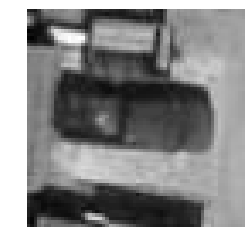

Guessed  0  was  1  probs [0.9981363  0.00186372]


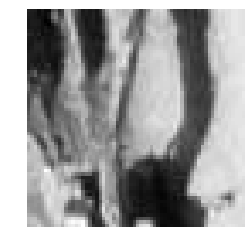

Guessed  0  was  1  probs [0.9980652  0.00193481]


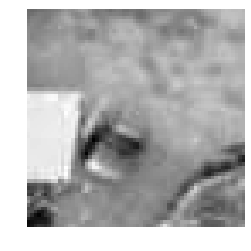

Guessed  1  was  0  probs [0.02296803 0.977032  ]


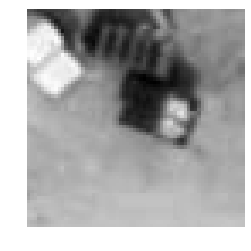

Guessed  0  was  1  probs [0.83995146 0.16004854]


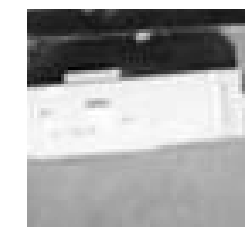

Guessed  1  was  0  probs [0.3135017  0.68649834]


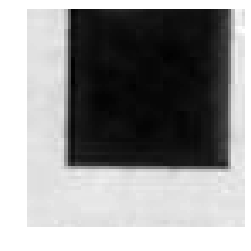

Guessed  0  was  1  probs [0.9608467  0.03915332]


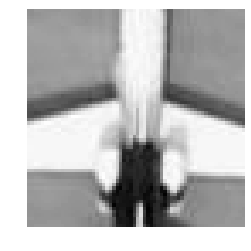

Guessed  1  was  0  probs [0.42810386 0.57189614]


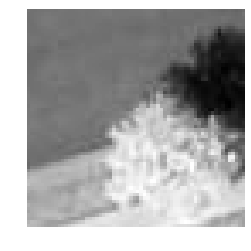

Guessed  0  was  1  probs [0.9768634  0.02313661]


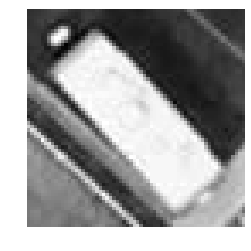

Guessed  1  was  0  probs [0.44648084 0.5535191 ]


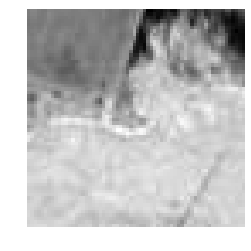

Guessed  1  was  0  probs [0.4336135  0.56638646]


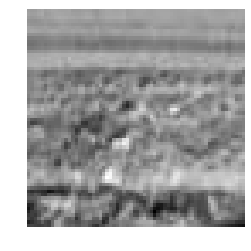

Guessed  0  was  1  probs [0.9949826  0.00501736]


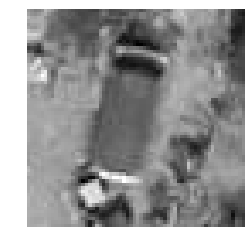

Guessed  0  was  1  probs [0.8328899 0.1671101]


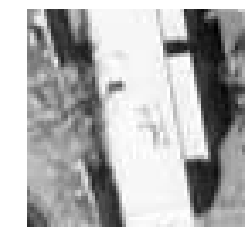

Guessed  0  was  1  probs [0.7624567  0.23754328]


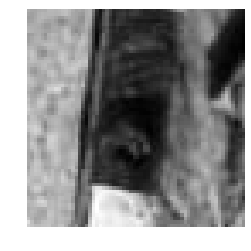

Guessed  1  was  0  probs [0.00645813 0.99354184]


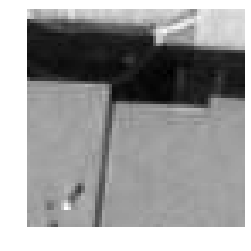

Guessed  1  was  0  probs [0.14697775 0.8530223 ]


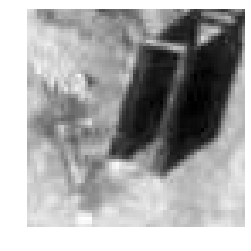

Guessed  1  was  0  probs [0.4651935 0.5348065]


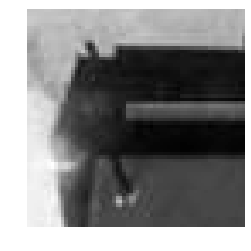

Guessed  1  was  0  probs [5.444519e-04 9.994555e-01]


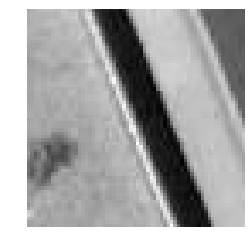

Guessed  1  was  0  probs [0.07095775 0.9290423 ]


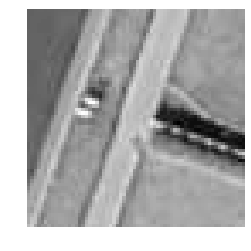

Guessed  1  was  0  probs [0.35730112 0.64269894]


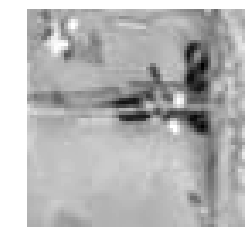

Guessed  0  was  1  probs [0.9897858 0.0102142]


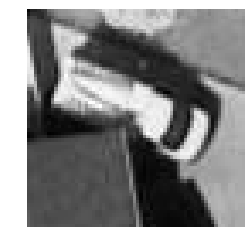

Guessed  0  was  1  probs [0.992663 0.007337]


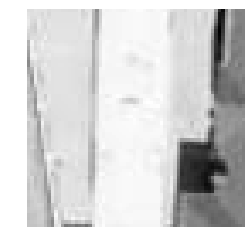

Guessed  0  was  1  probs [0.55463696 0.44536301]


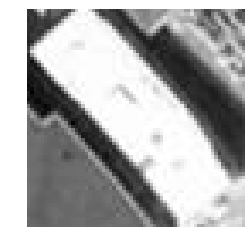

Guessed  1  was  0  probs [0.00303143 0.99696857]


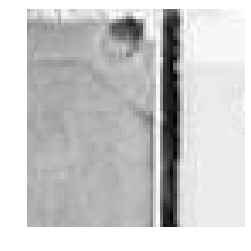

Guessed  0  was  1  probs [9.992250e-01 7.749378e-04]


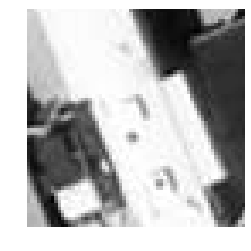

Guessed  0  was  1  probs [0.8957297  0.10427035]


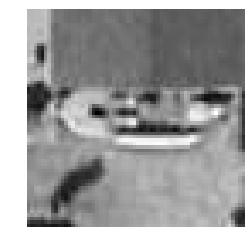

Guessed  1  was  0  probs [0.07098117 0.92901886]


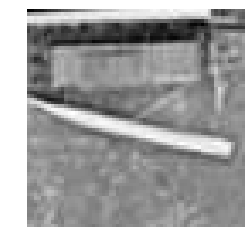

Guessed  0  was  1  probs [0.60704666 0.39295328]


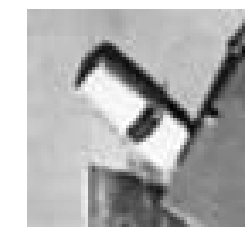

Guessed  1  was  0  probs [0.09822983 0.9017702 ]


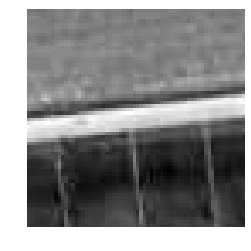

Guessed  0  was  1  probs [0.9441053  0.05589466]


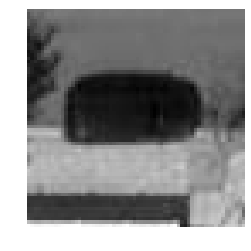

Guessed  1  was  0  probs [0.2580662 0.7419338]


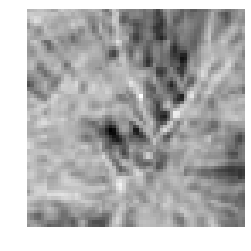

Guessed  1  was  0  probs [0.03985816 0.9601419 ]


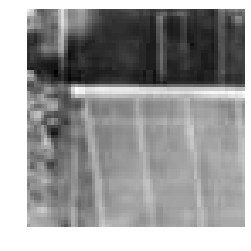

Guessed  1  was  0  probs [0.3606562 0.6393438]


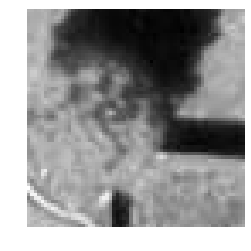

Guessed  1  was  0  probs [0.26638812 0.73361194]


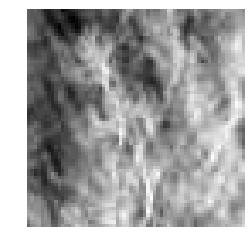

Guessed  0  was  1  probs [0.9320197  0.06798029]


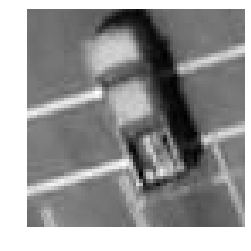

Guessed  0  was  1  probs [0.94452095 0.05547899]


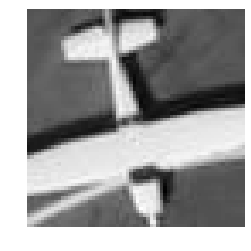

Guessed  1  was  0  probs [0.43385714 0.56614286]


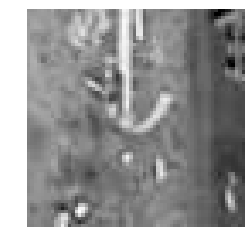

Guessed  1  was  0  probs [0.00989303 0.99010694]


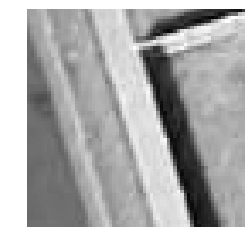

Guessed  0  was  1  probs [0.9249584  0.07504158]


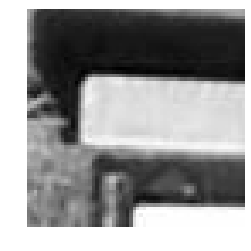

Guessed  1  was  0  probs [5.894989e-04 9.994105e-01]


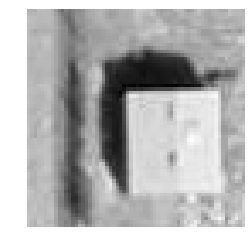

In [54]:
y_hat = model.predict(x_test)
for i in range(0, len(y_test)):
    if np.argmax(y_hat[i,:]) != y_test[i]:
        print("Guessed ", np.argmax(y_hat[i,:]), " was ", y_test[i], " probs", y_hat[i,:])
        plt.imshow(np.squeeze(x_test[i,:,:,:]), cmap='gray');
        plt.axis('off')
        plt.show()
        
